In [71]:
from OpenVisus import *
from backend_v2 import *
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pickle

### Original Gaussian

(50, 100, 50)


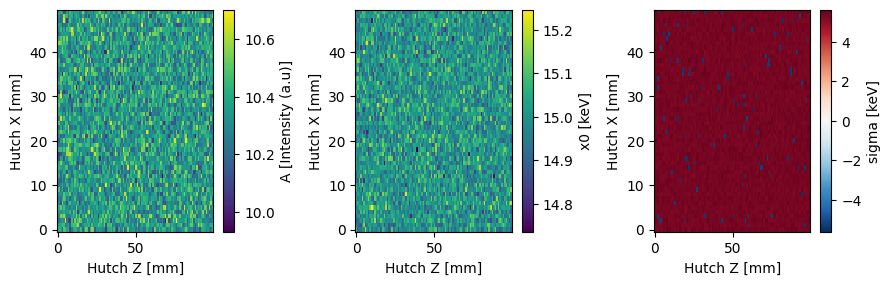

In [72]:
import xarray as xr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

# Just use some fake data for now.
data_shape = (50, 100, 50)
axes = [{'name':f'axis_{i}', 'size':d_s} for i,d_s in enumerate(data_shape)]
signal_axis = np.arange(data_shape[-1])
def gaussian(x, A, x0, sigma):
    return(A * np.e ** (-((x-x0)/(sigma*np.sqrt(2)))**2))
data = np.random.random(data_shape) + gaussian(signal_axis, 10,15,5)

parameters = np.empty((3, *data_shape[0:-1]))

print(data.shape)

for index in np.ndindex(*data_shape[0:-1]):
    popt = curve_fit(gaussian, signal_axis, data[index])
    parameters[0][index] = popt[0][0]
    parameters[1][index] = popt[0][1]
    parameters[2][index] = popt[0][2]
    
spectra_coords = {'x':('x',np.arange(data_shape[0]),{'units':'mm', 'long_name':'Hutch X'}),
                  'y':('y',np.arange(data_shape[1]),{'units':'mm', 'long_name':'Hutch Z'}),
                  'E':('E',np.arange(data_shape[2]),{'units':'keV', 'long_name':'MCA channel'})}
fit_coords = {'x':('x',np.arange(data_shape[0]),{'units':'mm', 'long_name':'Hutch X'}),
              'y':('y',np.arange(data_shape[1]),{'units':'mm', 'long_name':'Hutch Z'})}
data_vars = {'A':xr.DataArray(parameters[0], coords=fit_coords, attrs={'units':'Intensity (a.u)'}),
             'x0':xr.DataArray(parameters[1], coords=fit_coords, attrs={'units':'keV'}),
             'sigma':xr.DataArray(parameters[2], coords=fit_coords, attrs={'units':'keV'}),
             'spectra':xr.DataArray(data, coords=spectra_coords, attrs={'units':'Intensity (a.u)'})}


dset = xr.Dataset(data_vars=data_vars, coords=spectra_coords)

fig, axs = plt.subplots(1,3, figsize=(9, 3))
dset['A'].plot(ax=axs[0])
dset['x0'].plot(ax=axs[1])
dset['sigma'].plot(ax=axs[2])
fig.tight_layout()

In [73]:
dset

<xarray.Dataset>
Dimensions:  (x: 50, y: 100, E: 50)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
  * E        (E) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    A        (x, y) float64 10.27 10.43 10.4 10.18 ... 10.28 10.2 10.16 10.4
    x0       (x, y) float64 15.09 14.9 14.93 14.93 ... 15.1 15.09 14.99 14.98
    sigma    (x, y) float64 5.369 5.354 5.249 5.483 ... 5.405 5.536 5.488 5.291
    spectra  (x, y, E) float64 0.1766 0.9502 1.129 ... 0.119 0.2349 0.3084

In [74]:
spectra_coords = {'x':('x',np.arange(data_shape[0]),{'units':'mm', 'long_name':'Hutch X'}),
                  'y':('y',np.arange(data_shape[1]),{'units':'mm', 'long_name':'Hutch Z'}),
                  'E':('E',np.arange(data_shape[2]),{'units':'keV', 'long_name':'MCA channel'})}
fit_coords = {'x':('x',np.arange(data_shape[0]),{'units':'mm', 'long_name':'Hutch X'}),
              'y':('y',np.arange(data_shape[1]),{'units':'mm', 'long_name':'Hutch Z'})}
data_vars = {'A':xr.DataArray(parameters[0], coords=fit_coords, attrs={'units':'Intensity (a.u)'}),
             'x0':xr.DataArray(parameters[1], coords=fit_coords, attrs={'units':'keV'}),
             'sigma':xr.DataArray(parameters[2], coords=fit_coords, attrs={'units':'keV'}),
             'spectra':xr.DataArray(data, coords=spectra_coords, attrs={'units':'Intensity (a.u)'})}


### Convert to IDX

In [75]:
# filename='gauss1.idx'
# field=[Field('A','float64'),Field('x0','float64'),Field('sigma','float64')]
# db=CreateIdx(url=filename,fields=field,dims=[100,50],time=[0,0,'time%0000d/'])

In [76]:
# db.write(dset['A'].values,field='A',time=0)
# db.write(dset['x0'].values,field='x0',time=0)
# db.write(dset['sigma'].values,field='sigma',time=0)

In [77]:
# da_attrs={'units':'Intensity(a.u)'}
da_attrs={'A':{'units':'Intensity (a.u)'},
         'x0':{'units':'keV'},
         'sigma':{'units':'keV'}}

coords_attrs={'coords':spectra_coords,'attrs':da_attrs}

In [78]:
save_pickle(coords_attrs,'meta.pkl')

json saved locally


### Read from IDX

In [79]:
data=load_pickle('meta.pkl')

In [80]:
# db1=xr.open_dataset('gauss.idx',engine=OpenVisusBackendEntrypoint,da_attrs=data['attrs'],coords=data['coords'])
# data1=db1.isel(time=0,resolution=13)
# data1

In [81]:
# fig, axs = plt.subplots(1,3, figsize=(9, 3))
# data1['A'].plot(ax=axs[0])
# data1['x0'].plot(ax=axs[1])
# data1['sigma'].plot(ax=axs[2])
# fig.tight_layout()

In [82]:
import xarray as xr


ds = dset.copy()
ds=ds.drop('spectra')
ds['A'].dims

('x', 'y')

In [83]:
# overwrite the data variables with empty arrays
new_data_vars={}
emp=np.empty((50,100))
print(len(emp))
for var_name in ds.data_vars:
    new_data_vars[var_name] = xr.Variable(data=[],dims=ds[var_name].dims,attrs=ds[var_name].attrs)
empty_ds = xr.Dataset(new_data_vars,coords=ds.coords, attrs=ds.attrs)
empty_ds

50


ValueError: dimensions ('x', 'y') must have the same length as the number of data dimensions, ndim=1

In [84]:
empty_ds.to_netcdf('gauss1.nc')
empty_ds.close()

NameError: name 'empty_ds' is not defined

In [85]:
new=xr.open_dataset('old.nc')
new.variables.items()

ItemsView(Frozen({'x': <xarray.IndexVariable 'x' (x: 50)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
Attributes:
    units:      mm
    long_name:  Hutch X, 'y': <xarray.IndexVariable 'y' (y: 100)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Attributes:
    units:      mm
    long_name:  Hutch Z, 'A': <xarray.Variable (x: 50, y: 100)>
[5000 values with dtype=float64]
Attributes:
    units:    Intensity (a.u), 'x0': <xa

In [86]:
def open_dataset(filename):
    idx_file=filename[:-3]
    idx_file=idx_file+'.idx'
    print(idx_file)
    d=xr.open_dataset(filename)
    ds=xr.Dataset()
    db=LoadDataset(idx_file)
    for f in db.getFields():
        data=db.read(field=f)
        ds[f]=xr.DataArray(data,dims=d[f].dims,coords=d[f].coords,attrs=d[f].attrs)
        
    return ds


In [87]:
data=open_dataset('gauss1.nc')

gauss1.idx


In [88]:
data

<xarray.Dataset>
Dimensions:  (dim_0: 50, dim_1: 100)
Dimensions without coordinates: dim_0, dim_1
Data variables:
    A        (dim_0, dim_1) float64 10.34 10.29 10.24 10.41 ... 10.29 10.16 10.4
    x0       (dim_0, dim_1) float64 15.09 14.93 14.98 ... 15.03 14.97 14.83
    sigma    (dim_0, dim_1) float64 5.349 5.339 5.441 ... 5.318 5.491 5.401

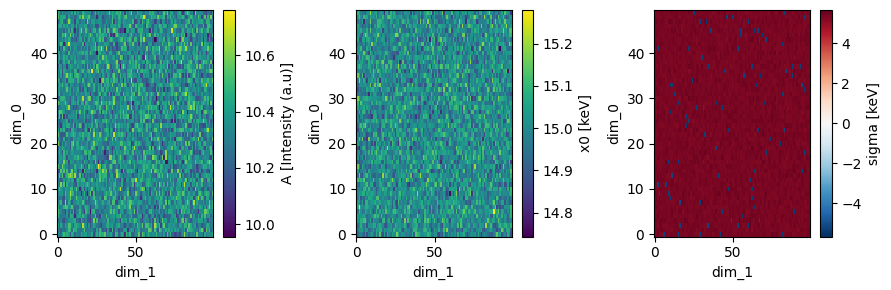

In [110]:
fig, axs = plt.subplots(1,3, figsize=(9, 3))
data['A'].plot(ax=axs[0])
data['x0'].plot(ax=axs[1])
data['sigma'].plot(ax=axs[2])
fig.tight_layout()

In [112]:
import xarray as xr

# Open the existing NetCDF file
ds = dset
# Create an empty data variable for each existing data variable
new_data_vars = {}
for varname in ds.data_vars:
    new_data_vars[varname] = ( [],ds[varname].dims)
print(new_data_vars)
# Create a new xarray dataset with the same metadata but without any data variables
new_ds = xr.Dataset(
    new_data_vars,
    coords=ds.coords,
    attrs=ds.attrs
)

# Save the new dataset to a NetCDF file
new_ds.to_netcdf('new_file.nc')
# new_ds

{'A': ([], ('x', 'y')), 'x0': ([], ('x', 'y')), 'sigma': ([], ('x', 'y')), 'spectra': ([], ('x', 'y', 'E'))}


ValueError: setting an array element with a sequence

In [109]:
a=xr.open_dataset('new_file.nc')
a

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [114]:
import xarray as xr

# Load the input netCDF file into an xarray Dataset
filename_in = 'old.nc'
ds = xr.open_dataset(filename_in)

# Remove duplicate values from the 'x' dimension
ds = ds.isel(x=~ds.indexes['x'].duplicated())

# Perform the desired operation that caused the error
# For example, reindexing along the 'x' dimension
ds_in = ds.reindex(x=new_x_values)
# Create a new xarray Dataset with the same metadata
ds_out = xr.Dataset(attrs=ds_in.attrs)

# Copy the coordinate variables from the input dataset
for coord_name, coord in ds_in.coords.items():
    ds_out[coord_name] = coord

# Copy the data variables from the input dataset, but with no data
for var_name, var in ds_in.variables.items():
    dims = var.dims
    attrs = var.attrs
    data = xr.DataArray(np.zeros(var.shape, dtype=var.dtype), dims=dims, attrs=attrs)
    ds_out[var_name] = data

# Save the output netCDF file
filename_out = 'output.nc'
ds_out.to_netcdf(filename_out)


NameError: name 'new_x_values' is not defined

In [67]:
import xarray as xr

# Open the source netCDF file
source_ds = xr.open_dataset('old.nc')
source_ds=source_ds.drop('spectra')


new_ds = xr.Dataset(coords=ds.coords, attrs=ds.attrs)
# Create a new xarray dataset with the same dimensions as the source file
new_ds = xr.Dataset(coords=source_ds.coords, attrs=source_ds.attrs)

# Copy the metadata from the source dataset to the new dataset
new_ds.attrs = source_ds.attrs

# new_var={}
# for f in source_ds.data_vars:
#     new_attrs=source_ds[f].attrs
#     new_dims=source_ds[f].dims
#     new_var[f] = xr.Variable(new_dims, [[]], new_attrs)


  
# Save the new dataset to the destination netCDF file
new_ds.to_netcdf('destination_file.nc')


In [68]:
d=xr.open_dataset('destination_file.nc')
d

<xarray.Dataset>
Dimensions:  (x: 50, y: 100, E: 50)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
  * E        (E) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    *empty*

In [58]:
d=xr.open_dataset('nnn.nc')
d.A.values

FileNotFoundError: [Errno 2] No such file or directory: b'/home/sci/aashishp/Xarray_openv/xarray_OpenV/Samples/chess_gaussian/nnn.nc'